## Week 4, Lab 2: Predicting Chronic Kidney Disease in Patients
> Author: Matt Brems

We can sketch out the data science process as follows:
1. Define the problem.
2. Obtain the data.
3. Explore the data.
4. Model the data.
5. Evaluate the model.
6. Answer the problem.

In this lab, we're going to focus on steps exploring data, building models and evaluating the models we build.

There are three links you may find important:
- [A set of chronic kidney disease (CKD) data and other biological factors](./chronic_kidney_disease_full.csv).
- [The CKD data dictionary](./chronic_kidney_disease_header.txt).
- [An article comparing the use of k-nearest neighbors and support vector machines on predicting CKD](./chronic_kidney_disease.pdf).

## Step 1: Define the problem.

Suppose you're working for Mayo Clinic, widely recognized to be the top hospital in the United States. In your work, you've overheard nurses and doctors discuss test results, then arrive at a conclusion as to whether or not someone has developed a particular disease or condition. For example, you might overhear something like:

> **Nurse**: Male 57 year-old patient presents with severe chest pain. FDP _(short for fibrin degradation product)_ was elevated at 13. We did an echo _(echocardiogram)_ and it was inconclusive.

> **Doctor**: What was his interarm BP? _(blood pressure)_

> **Nurse**: Systolic was 140 on the right; 110 on the left.

> **Doctor**: Dammit, it's an aortic dissection! Get to the OR _(operating room)_ now!

> _(intense music playing)_

In this fictitious but [Shonda Rhimes-esque](https://en.wikipedia.org/wiki/Shonda_Rhimes#Grey's_Anatomy,_Private_Practice,_Scandal_and_other_projects_with_ABC) scenario, you might imagine the doctor going through a series of steps like a [flowchart](https://en.wikipedia.org/wiki/Flowchart), or a series of if-this-then-that steps to diagnose a patient. The first steps made the doctor ask what the interarm blood pressure was. Because interarm blood pressure took on the values it took on, the doctor diagnosed the patient with an aortic dissection.

Your goal, as a research biostatistical data scientist at the nation's top hospital, is to develop a medical test that can improve upon our current diagnosis system for [chronic kidney disease (CKD)](https://www.mayoclinic.org/diseases-conditions/chronic-kidney-disease/symptoms-causes/syc-20354521).

**Real-world problem**: Develop a medical diagnosis test that is better than our current diagnosis system for CKD.

**Data science problem**: Develop a medical diagnosis test that reduces both the number of false positives and the number of false negatives.

---

## Step 2: Obtain the data.

### 1. Read in the data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso
from sklearn.metrics import confusion_matrix

In [2]:
data = pd.read_csv('chronic_kidney_disease_full.csv')
data.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,class
0,48.0,80.0,1.020,1.0,0.0,NaN,normal,notpresent,notpresent,121.0,...,44.0,7800.0,5.2,yes,yes,no,good,no,no,ckd
1,7.0,50.0,1.020,4.0,0.0,NaN,normal,notpresent,notpresent,NaN,...,38.0,6000.0,NaN,no,no,no,good,no,no,ckd
2,62.0,80.0,1.010,2.0,3.0,normal,normal,notpresent,notpresent,423.0,...,31.0,7500.0,NaN,no,yes,no,poor,no,yes,ckd
3,48.0,70.0,1.005,4.0,0.0,normal,abnormal,present,notpresent,117.0,...,32.0,6700.0,3.9,yes,no,no,poor,yes,yes,ckd
4,51.0,80.0,1.010,2.0,0.0,normal,normal,notpresent,notpresent,106.0,...,35.0,7300.0,4.6,no,no,no,good,no,no,ckd


### 2. Check out the data dictionary. What are a few features or relationships you might be interested in checking out?

In [3]:
data.columns

Index(['age', 'bp', 'sg', 'al', 'su', 'rbc', 'pc', 'pcc', 'ba', 'bgr', 'bu',
       'sc', 'sod', 'pot', 'hemo', 'pcv', 'wbcc', 'rbcc', 'htn', 'dm', 'cad',
       'appet', 'pe', 'ane', 'class'],
      dtype='object')

Answer:

From link (https://www.google.com/search?q=chronic+kidney+disease+signs+and+symptoms&oq=chronic+kidney+disease+signs&aqs=chrome.0.0j69i57j0l4.7215j1j7&sourceid=chrome&ie=UTF-8), the signs and symptoms of CKD which match those in the data are:

1. ane (=anemia)
2. bu, blood urea (=blood in urine)
3. pe, pedal anemia (=edema - swollen feet, hands, and ankles (face if edema is severe))
4. bp, blood pressure (=hypertension (high blood pressure))
5. appet, appetite (=loss of appetite)

amongst many others which are not in the data:

dark urine,
decreased mental alertness,
decreased urine output,
fatigue (tiredness),
insomnia,
itchy skin, can become persistent,
male inability to get or maintain an erection (erectile dysfunction),
more frequent urination, especially at night,
muscle cramps,
muscle twitches,
nausea,
pain on the side or mid to lower back,
panting (shortness of breath),
protein in urine,
sudden change in bodyweight,
unexplained headaches

---

## Step 3: Explore the data.

### 3. How much of the data is missing from each column?

In [4]:
data.info()

# some nulls for all columns, except 'class'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 25 columns):
age      391 non-null float64
bp       388 non-null float64
sg       353 non-null float64
al       354 non-null float64
su       351 non-null float64
rbc      248 non-null object
pc       335 non-null object
pcc      396 non-null object
ba       396 non-null object
bgr      356 non-null float64
bu       381 non-null float64
sc       383 non-null float64
sod      313 non-null float64
pot      312 non-null float64
hemo     348 non-null float64
pcv      329 non-null float64
wbcc     294 non-null float64
rbcc     269 non-null float64
htn      398 non-null object
dm       398 non-null object
cad      398 non-null object
appet    399 non-null object
pe       399 non-null object
ane      399 non-null object
class    400 non-null object
dtypes: float64(14), object(11)
memory usage: 78.2+ KB


### 4. Suppose that I dropped every row that contained at least one missing value. (In the context of analysis with missing data, we call this a "complete case analysis," because we keep only the complete cases!) How many rows would remain in our dataframe? What are at least two downsides to doing this?

> There's a good visual on slide 15 of [this deck](https://liberalarts.utexas.edu/prc/_files/cs/Missing-Data.pdf) that shows what a complete case analysis looks like if you're interested.

In [5]:
data.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 3 to 399
Data columns (total 25 columns):
age      158 non-null float64
bp       158 non-null float64
sg       158 non-null float64
al       158 non-null float64
su       158 non-null float64
rbc      158 non-null object
pc       158 non-null object
pcc      158 non-null object
ba       158 non-null object
bgr      158 non-null float64
bu       158 non-null float64
sc       158 non-null float64
sod      158 non-null float64
pot      158 non-null float64
hemo     158 non-null float64
pcv      158 non-null float64
wbcc     158 non-null float64
rbcc     158 non-null float64
htn      158 non-null object
dm       158 non-null object
cad      158 non-null object
appet    158 non-null object
pe       158 non-null object
ane      158 non-null object
class    158 non-null object
dtypes: float64(14), object(11)
memory usage: 32.1+ KB


Answer:

From 400 rows, it dropped to 158 rows. 
1. We have lost >50% of our data, hence less data to train with, to produce a reliable model. 
2. Also, the data would be more biased. eg. in a dataset of students' GRE scores and their admission status into Uni (nan if failed to enter. which likely happens to those with low GRE scores), if we omit the rows with admission status as 'nan', we'd only be looking mainly at students with high GRE scores. There'd be selection bias here   

### 5. Thinking critically about how our data were gathered, it's likely that these records were gathered by doctors and nurses. Brainstorm three potential areas (in addition to the missing data we've already discussed) where this data might be inaccurate or imprecise.

Answer:

1. The patient may not have adhered (fully) to the doc's instructions to fast before blood tests, and that may have affected his blood-related readings.
2. The patient may not have given an accurate answer regarding eg. his appetite level. 
3. Different doctors/nurses may have different skill levels, and may not have identified symptoms like pus cell/pus cell clumps.
4. Data entry errors

---

## Step 4: Model the data.

### 6. Suppose that I want to construct a model where no person who has CKD will ever be told that they do not have CKD. What (very simple, no machine learning needed) model can I create that will never tell a person with CKD that they do not have CKD?

> Hint: Don't think about `statsmodels` or `scikit-learn` here.

Answer:

We want to maximise sensitivity (TP/(TP+FN)). Simply predict that EVERYONE has CKD.

### 7. In problem 6, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:

We maximised TP, hence we are minimizing FN.

### 8. Thinking ethically, what is at least one disadvantage to the model you described in problem 6?

Answer:

We'd be having a high false positive rate, hence many people would be made unduly worried about their health.  

### 9. Suppose that I want to construct a model where a person who does not have CKD will ever be told that they do have CKD. What (very simple, no machine learning needed) model can I create that will accomplish this?

Answer:

We want to maximise specificity (TN/(TN+FP)). Simply predict that EVERYONE has no CKD.

### 10. In problem 9, what common classification metric did we optimize for? Did we minimize false positives or negatives?

Answer:

We maximised TN, hence we are minimizing FP.

### 11. Thinking ethically, what is at least one disadvantage to the model you described in problem 9?

Answer:

There would be many who have CKD, but are told that they don't. We'd be jeopardising their health.

### 12. Construct a logistic regression model in `sklearn` predicting class from the other variables. You may scale, select/drop, and engineer features as you wish - build a good model! Make sure, however, that you include at least one categorical/dummy feature and at least one quantitative feature.

> Hint: Remember to do a train/test split!

In [6]:
data.describe()

,age,bp,sg,al,su,bgr,bu,sc,sod,pot,hemo,pcv,wbcc,rbcc
count,391.000000,388.000000,353.000000,354.000000,351.000000,356.000000,381.000000,383.000000,313.000000,312.000000,348.000000,329.000000,294.000000,269.000000
mean,51.483376,76.469072,1.017408,1.016949,0.450142,148.036517,57.425722,3.072454,137.528754,4.627244,12.526437,38.884498,8406.122449,4.707435
std,17.169714,13.683637,0.005717,1.352679,1.099191,79.281714,50.503006,5.741126,10.408752,3.193904,2.912587,8.990105,2944.474190,1.025323
min,2.000000,50.000000,1.005000,0.000000,0.000000,22.000000,1.500000,0.400000,4.500000,2.500000,3.100000,9.000000,2200.000000,2.100000
25%,42.000000,70.000000,1.010000,0.000000,0.000000,99.000000,27.000000,0.900000,135.000000,3.800000,10.300000,32.000000,6500.000000,3.900000
50%,55.000000,80.000000,1.020000,0.000000,0.000000,121.000000,42.000000,1.300000,138.000000,4.400000,12.650000,40.000000,8000.000000,4.800000
75%,64.500000,80.000000,1.020000,2.000000,0.000000,163.000000,66.000000,2.800000,142.000000,4.900000,15.000000,45.000000,9800.000000,5.400000
max,90.000000,180.000000,1.025000,5.000000,5.000000,490.000000,391.000000,76.000000,163.000000,47.000000,17.800000,54.000000,26400.000000,8.000000


In [7]:
# extract only the numerical features to perform VIF on them, to remove highly collinear features
data_num = data
for col in data_num.columns:
    if data_num[col].dtype==object:
        data_num = data_num.drop(columns=[col])

# drop null rows
data_num = data_num.dropna()

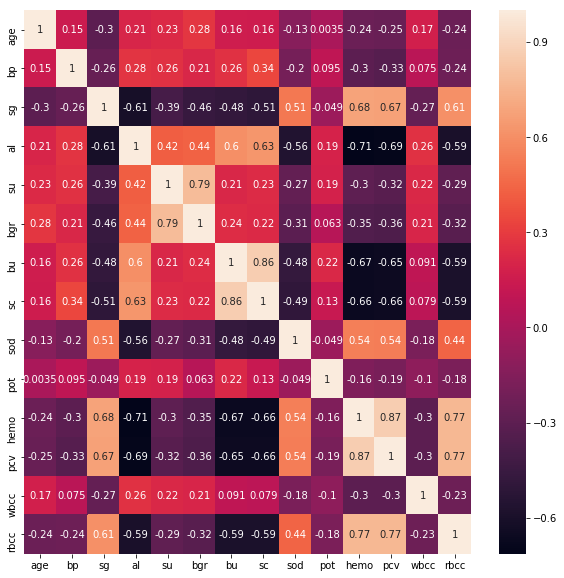

In [8]:
# heatmap to identify highly correlated features 
import seaborn as sns
plt.figure(figsize=(10,10))
sns.heatmap(data_num.corr(), annot=True);

Some numerical features are highly correlated with each other:
1. pcv, hemo (0.87)
2. rbcc, hemo (0.77)
3. rbcc, pcv (0.77)

and a few other somewhat high pairs too. Lets remove either 1 of them via VIF.

In [9]:
from statsmodels.stats.outliers_influence import variance_inflation_factor    

def calculate_vif_(X, thresh=5):    #lets  set threshold  at 5 
    cols = X.columns
    variables = np.arange(X.shape[1])
    drop_cols = []
    dropped=True
    while dropped:
        dropped=False
        c = X[cols[variables]].values
        vif = [variance_inflation_factor(c, ix) for ix in np.arange(c.shape[1])]

        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print('dropping \'' + X[cols[variables]].columns[maxloc] + '\' at index: ' + str(maxloc))
            drop_cols.append(X[cols[variables]].columns[maxloc])
            variables = np.delete(variables, maxloc)
            dropped=True

    print('Remaining variables:')
    print(X.columns[variables])
    return X[cols[variables]], drop_cols

data_num_VIF, drop_cols = calculate_vif_(data_num)

dropping 'sg' at index: 2
dropping 'sod' at index: 7
dropping 'hemo' at index: 8
dropping 'rbcc' at index: 10
dropping 'bp' at index: 1
dropping 'pcv' at index: 7
dropping 'bgr' at index: 3
dropping 'bu' at index: 3
dropping 'age' at index: 0
Remaining variables:
Index(['al', 'su', 'sc', 'pot', 'wbcc'], dtype='object')


We will hence only keep cols ['al', 'su', 'sc', 'pot', 'wbcc'] in data_num_VIF.

Now lets remove categorical features, which aren't highly related to the target.

In [10]:
from sklearn.feature_selection import SelectKBest, chi2

# define function to perform chi2 test
def chi2_feature_selection(X_categorical, y, k_number):
    # initialise chi2 model     
    skb_chi2 = SelectKBest(chi2, k = k_number) 
      
    # fit transform
    X_categorical_chi2 = skb_chi2.fit_transform(X_categorical, y)
    
    # get retained features, get the output dataframe 
    mask = skb_chi2.get_support()
    retained_categorical_features = X_categorical.columns[mask]
    X_categorical_chi2 = pd.DataFrame(X_categorical_chi2, columns = retained_categorical_features)
    
    return X_categorical_chi2, skb_chi2, retained_categorical_features;

In [11]:
# extract only the categorical features to perform chi2 on them, to remove features that aren't related to target
data_cat = data
for col in data_cat.columns:
    if data_cat[col].dtype!=object:
        data_cat = data_cat.drop(columns=[col])

# drop null rows
data_cat = data_cat.dropna()
data_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 2 to 399
Data columns (total 11 columns):
rbc      233 non-null object
pc       233 non-null object
pcc      233 non-null object
ba       233 non-null object
htn      233 non-null object
dm       233 non-null object
cad      233 non-null object
appet    233 non-null object
pe       233 non-null object
ane      233 non-null object
class    233 non-null object
dtypes: object(11)
memory usage: 21.8+ KB


In [12]:
features = [k for k in data_cat if k!='class']
data_cat_X = data_cat[features]
data_cat_y = np.where(data_cat['class']=='ckd', 1,0)

In [13]:
data_cat_X.columns

Index(['rbc', 'pc', 'pcc', 'ba', 'htn', 'dm', 'cad', 'appet', 'pe', 'ane'], dtype='object')

In [14]:
# create k-1 dummy cols 
data_cat_X = pd.get_dummies(data_cat_X, drop_first=True)

In [15]:
data_cat_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233 entries, 2 to 399
Data columns (total 10 columns):
rbc_normal     233 non-null uint8
pc_normal      233 non-null uint8
pcc_present    233 non-null uint8
ba_present     233 non-null uint8
htn_yes        233 non-null uint8
dm_yes         233 non-null uint8
cad_yes        233 non-null uint8
appet_poor     233 non-null uint8
pe_yes         233 non-null uint8
ane_yes        233 non-null uint8
dtypes: uint8(10)
memory usage: 4.1 KB


In [16]:
data_cat_y.shape

(233,)

In [17]:
# tried lr, ridge, but yields only -ve r2_adj. Hence we try lasso 
lasso = Lasso()
for k in range(1,len(data_cat_X.columns)+1):    #start from retaining 1 categorical feature, to all features
    data_cat_X_chi2, skb_chi2, retained_categorical_features = chi2_feature_selection(data_cat_X, data_cat_y, k)
    r2 = cross_val_score(lasso, data_cat_X_chi2, data_cat_y, cv=5).mean()
    r2_adj = 1-((1-r2**2)*(data_cat_X_chi2.shape[0]-1)/(data_cat_X_chi2.shape[0]-data_cat_X_chi2.shape[1]-1))
    print(retained_categorical_features)
    print(k,r2_adj)

Index(['htn_yes'], dtype='object')
1 0.20239167976747874
Index(['htn_yes', 'dm_yes'], dtype='object')
2 0.19892381750559818
Index(['htn_yes', 'dm_yes', 'pe_yes'], dtype='object')
3 0.19542566823706364
Index(['htn_yes', 'dm_yes', 'appet_poor', 'pe_yes'], dtype='object')
4 0.19189683344862973
Index(['htn_yes', 'dm_yes', 'appet_poor', 'pe_yes', 'ane_yes'], dtype='object')
5 0.18833690760479105
Index(['pcc_present', 'htn_yes', 'dm_yes', 'appet_poor', 'pe_yes', 'ane_yes'], dtype='object')
6 0.1847454779924229
Index(['pc_normal', 'pcc_present', 'htn_yes', 'dm_yes', 'appet_poor', 'pe_yes',
       'ane_yes'],
      dtype='object')
7 0.18112212456127808
Index(['pc_normal', 'pcc_present', 'ba_present', 'htn_yes', 'dm_yes',
       'appet_poor', 'pe_yes', 'ane_yes'],
      dtype='object')
8 0.17746641976021238
Index(['pc_normal', 'pcc_present', 'ba_present', 'htn_yes', 'dm_yes',
       'cad_yes', 'appet_poor', 'pe_yes', 'ane_yes'],
      dtype='object')
9 0.17377792836900263
Index(['rbc_normal', '

Having Hypertension (htn_yes) seems to be the most related categorical feature (highest r2_adj 0.202), to the target. All other categorical features only worsen the r2_adj. Hence lets keep only htn_yes from all categorical features. 

In [18]:
data_cat_X_chi2.shape

(233, 10)

In [19]:
# take numerical features filtered by VIF
data_VIF_chi2 = data[data_num_VIF.columns]

# take categorical feature filtered by chi2
data_VIF_chi2['htn'] = np.where(data['htn']=='yes',1,0)

# include target, convert yes/no to 1/0, and check no. of nulls
data_VIF_chi2['class'] = np.where(data['class']=='ckd',1,0)
data_VIF_chi2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 7 columns):
al       354 non-null float64
su       351 non-null float64
sc       383 non-null float64
pot      312 non-null float64
wbcc     294 non-null float64
htn      400 non-null int32
class    400 non-null int32
dtypes: float64(5), int32(2)
memory usage: 18.8 KB


C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Many nulls to drop.

In [20]:
# drop nulls
data_VIF_chi2 = data_VIF_chi2.dropna()
data_VIF_chi2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226 entries, 3 to 399
Data columns (total 7 columns):
al       226 non-null float64
su       226 non-null float64
sc       226 non-null float64
pot      226 non-null float64
wbcc     226 non-null float64
htn      226 non-null int32
class    226 non-null int32
dtypes: float64(5), int32(2)
memory usage: 12.4 KB


We finally have our VIF & chi2 selected dataset. Now, to split into X/y, train/test, scaling.

In [21]:
features = [k for k in data_VIF_chi2.columns if k!='class']
X = data_VIF_chi2[features]
y = data_VIF_chi2['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)  #stratify to mitigate class imbalance

In [22]:
X_train.head()

,al,su,sc,pot,wbcc,htn
281,0.0,0.0,1.2,5.0,9100.0,0
366,0.0,0.0,0.5,3.6,10500.0,0
278,0.0,0.0,1.2,4.9,9400.0,0
126,0.0,0.0,4.0,4.6,8200.0,1
385,0.0,0.0,0.6,4.9,8000.0,0


In [23]:
# let scale data be a duplicate of unscaled data. We will scale them right after
X_train_s = X_train
X_test_s = X_test

# scaling
scaler = StandardScaler()
X_train_s[['al','su','sc','pot','wbcc']] = scaler.fit_transform(X_train[['al','su','sc','pot','wbcc']])
X_test_s[['al','su','sc','pot','wbcc']] = scaler.transform(X_test[['al','su','sc','pot','wbcc']])#only transform, not fit! 

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Dell\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [24]:
X_train_s.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 281 to 92
Data columns (total 6 columns):
al      180 non-null float64
su      180 non-null float64
sc      180 non-null float64
pot     180 non-null float64
wbcc    180 non-null float64
htn     180 non-null int32
dtypes: float64(5), int32(1)
memory usage: 9.1 KB


In [25]:
logreg = LogisticRegression()   # init logreg
logreg.fit(X_train_s, y_train)    # fit logreg model
print('accuracy or score (train) =',logreg.score(X_train_s, y_train))
print('accuracy or score (test)  =',logreg.score(X_test_s, y_test))
y_predict = logreg.predict(X_test_s)
print('predictions =',list(y_predict))
print('actual      =',list(y_test))

values, counts = np.unique(y_train, return_counts=True)
print('\n% of 1s:',counts[1]/len(counts))

accuracy or score (train) = 0.9555555555555556
accuracy or score (test)  = 0.9782608695652174
predictions = [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0]
actual      = [1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0]

% of 1s: 38.0


C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Extremely high accuracy (95-97%), on a somewhat balanced test dataset. 

---

## Step 5: Evaluate the model.

### 13. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your quantitative features.

In [26]:
print(X_train_s.columns)
print('coef =',logreg.coef_[0,:])    #1st 5 are numerical features, last is a categorical feature

Index(['al', 'su', 'sc', 'pot', 'wbcc', 'htn'], dtype='object')
coef = [ 2.04441542  0.72059625  1.96748232 -0.5193693   0.7628382   2.36609271]


As albumin (al), sugar (su), serum creatinine (sc), white blood cell count (wbcc) INCREASE by 1 unit, the odds change by a factor of e^2.04441542, e^0.72059625, e^1.96748232, e^0.7628382 times respectively, an INCREASE.

As potassium (pot) levels INCREASE by 1 unit, the odds change by a factor of e^(-0.5193693), a DECREASE.

### 14. Based on your logistic regression model constructed in problem 12, interpret the coefficient of one of your categorical/dummy features.

As seen in qn13, with hypertension (htn), the odds change by a factor of e^(2.36609271), an INCREASE.

### 15. Despite being a relatively simple model, logistic regression is very widely used in the real world. Why do you think that's the case? Name at least two advantages to using logistic regression as a modeling technique.

Answer:

1. Many scenarios involve classification of categorical features, which requires logreg (amongst other techniques), not linreg (only for continuous features).
2. Even if the features are continuous, classification may still be required to classify the data into different clusters - especially if the data is unlabelled, which is common.   

### 16. Does it make sense to generate a confusion matrix on our training data or our test data? Why? Generate it on the proper data.

> Hint: Once you've generated your predicted $y$ values and you have your observed $y$ values, then it will be easy to [generate a confusion matrix using sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html).

Answer: Confusion matrix should be generated on the test data, to ascertain the effectiveness of training the logreg model on the training data. 

In [27]:
pd.DataFrame(confusion_matrix(y_predict, y_test), columns=['Pred_F','Pred_T'], index=['Actual_F','Actual_T'])

,Pred_F,Pred_T
Actual_F,26,1
Actual_T,0,19


### 17. In this hospital case, we want to predict CKD. Do we want to optimize for sensitivity, specificity, or something else? Why? (If you don't think there's one clear answer, that's okay! There rarely is. Be sure to defend your conclusion!)

Answer:
We want to maximise Sensitivity (TP/(TP+FN)), as the impact on one's kidneys is irreversible and can severly impact the kidneys' functions. Also, CKD worsens "silently". Clearly, it is then better to have early intervention at Stage 1 (by Stage 3, much kidney funtionality would have been reduced, and the patient's health/quality of life/wealth would have been sizeably impacted) to keep it from progressing, hence it is better to be "overly prudent".

Doing so does raise reduce the Specificity (TN/(TN+FP)), hence causing much unecessary anguish (and likely time and cost) amongst the false positive (FP) patients. But with regular checkups, and improvements in medical tests, the FPs should  over time reduce in number.

Source:
https://www.google.com/search?sxsrf=ACYBGNRpz8WxCDcqWTu2u4WsgZV_p-HIqg%3A1574661615131&ei=723bXYzaB9vF4-EPzIa5uAI&q=ckd+stages+reversible&oq=ckd+stages+reversible&gs_l=psy-ab.3..0i22i30l3j0i333l2.32655.34074..34256...0.2..1.210.1280.6j4j1......0....1..gws-wiz.......0i71j0j0i67j0i20i263.2WBWIsXgZvU&ved=0ahUKEwjMjdjR14TmAhXb4jgGHUxDDicQ4dUDCAs&uact=5

### 18 (BONUS). Write a function that will create an ROC curve for you, then plot the ROC curve.

Here's a strategy you might consider:
1. In order to even begin, you'll need some fit model. Use your logistic regression model from problem 12.
2. We want to look at all values of your "threshold" - that is, anything where .predict() gives you above your threshold falls in the "positive class," and anything that is below your threshold falls in the "negative class." Start the threshold at 0.
3. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
4. Increment your threshold by some "step." Maybe set your step to be 0.01, or even smaller.
5. At this value of your threshold, calculate the sensitivity and specificity. Store these values.
6. Repeat steps 3 and 4 until you get to the threshold of 1.
7. Plot the values of sensitivity and 1 - specificity.

In [28]:
# Let's create a dataframe called pred_df that contains:
# 1. The list of true values of our test set.
# 2. The list of predicted probabilities based on our model.

pred_proba = [i[1] for i in logreg.predict_proba(X_test_s)]    #[0] contains 1-p, [1] contains p

pred_df = pd.DataFrame({'true_values': y_test,
                        'pred_probs':pred_proba})

In [29]:
pred_df.head()

,true_values,pred_probs
3,1,0.999569
20,1,0.993545
111,1,0.999894
285,0,0.037806
9,1,0.999694


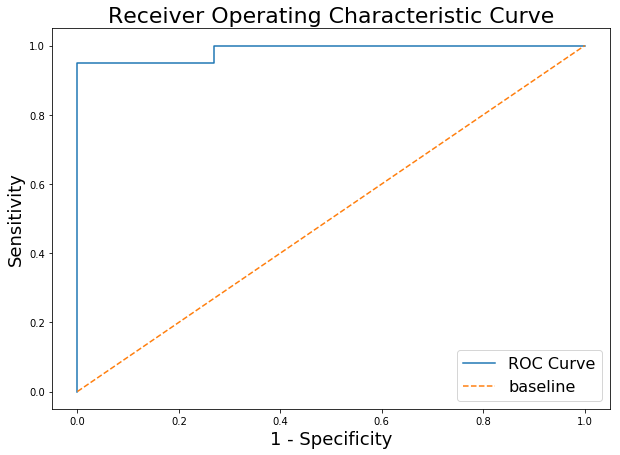

In [30]:
# Create figure.
plt.figure(figsize = (10,7))

# Create threshold values.
thresholds = np.linspace(0, 1, 200)

# Define function to calculate sensitivity. (True positive rate.)
def TPR(df, true_col, pred_prob_col, threshold):
    true_positive = df[(df[true_col] == 1) & (df[pred_prob_col] >= threshold)].shape[0]
    false_negative = df[(df[true_col] == 1) & (df[pred_prob_col] < threshold)].shape[0]
    return true_positive / (true_positive + false_negative)

# Define function to calculate 1 - specificity. (False positive rate.)
def FPR(df, true_col, pred_prob_col, threshold):
    true_negative = df[(df[true_col] == 0) & (df[pred_prob_col] <= threshold)].shape[0]
    false_positive = df[(df[true_col] == 0) & (df[pred_prob_col] > threshold)].shape[0]
    return 1 - (true_negative / (true_negative + false_positive))
    
# Calculate sensitivity & 1-specificity for each threshold between 0 and 1.
tpr_values = [TPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]
fpr_values = [FPR(pred_df, 'true_values', 'pred_probs', prob) for prob in thresholds]

# Plot ROC curve.
plt.plot(fpr_values, # False Positive Rate on X-axis
         tpr_values, # True Positive Rate on Y-axis
         label='ROC Curve')

# Plot baseline. (Perfect overlap between the two populations.)
plt.plot(np.linspace(0, 1, 200),
         np.linspace(0, 1, 200),
         label='baseline',
         linestyle='--')

# Label axes.
plt.title('Receiver Operating Characteristic Curve', fontsize=22)
plt.ylabel('Sensitivity', fontsize=18)
plt.xlabel('1 - Specificity', fontsize=18)

# Create legend.
plt.legend(fontsize=16);

### 19. Suppose you're speaking with the biostatistics lead at Mayo Clinic, who asks you "Why are unbalanced classes generally a problem? Are they a problem in this particular CKD analysis?" How would you respond?

In [31]:
# for target y_train
values, counts = np.unique(y_train, return_counts=True)
print('No. of 0       :',counts[0])
print('Proportion of 0:',counts[0]/counts.sum())
print('\nNo. of 1       :',counts[1])
print('Proportion of 1:',counts[1]/counts.sum())

No. of 0       : 104
Proportion of 0: 0.5777777777777777

No. of 1       : 76
Proportion of 1: 0.4222222222222222


Answer:

1. As seen from the above, the distribution of 1's and 0's aren't terribly unbalanced (~40/60 split). Hence it is not a problem in this CKD analysis.

2. 
    a. Unbalanced classes (eg. disproportionately large numbers of a class of elements in the dataset, like 99% of classes in target being 1's, remaining being 0's) would inaccurately raise the accuracy ((TP+TN)/(TP+TN+FP+FN) = 99/100 in the example dataframe below) and the precision (TP/(TP+FP) = 99/100 in the example dataframe below) of the test if one were to predict 1's entirely, since almost all predictions (99%) would be correct then. These would give a false impression of good performance.
    
    b. Training of the unbalanced dataset would cause the machine learning model to learn wrongly (always predicting 1's in the ongoing example, as the model aims to maximise accuracy), yielding inaccurate results.

(Sources: 
https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/, 

https://en.wikipedia.org/wiki/Accuracy_paradox, 

https://medium.com/james-blogs/handling-imbalanced-data-in-classification-problems-7de598c1059f)

In [32]:
# example dataframe
pd.DataFrame([[0,1],[0,99]], columns=['Pred_F','Pred_T'], index=['Actual_F','Actual_T'])

,Pred_F,Pred_T
Actual_F,0,1
Actual_T,0,99


### 20. Suppose you're speaking with a doctor at Mayo Clinic who, despite being very smart, doesn't know much about data science or statistics. How would you explain why unbalanced classes are generally a problem to this doctor?

Answer:
Answer as mentioned in qn19 above. By always predicting 'Yes' for CKD, the doctor would cause much anguish for patients who don't actually have CKD.

### 21. Let's create very unbalanced classes just for the sake of this example! Generate very unbalanced classes by [bootstrapping](http://stattrek.com/statistics/dictionary.aspx?definition=sampling_with_replacement) (a.k.a. random sampling with replacement) the majority class.

1. The majority class are those individuals with CKD.
2. Generate a random sample of size 200,000 of individuals who have CKD **with replacement**. (Consider setting a random seed for this part!)
3. Create a new dataframe with the original data plus this random sample of data.
4. Now we should have a dataset with around 200,000 observations, of which only about 0.00075% are non-CKD individuals.

In [33]:
# still having just those 5 numerical + 1 categorical features...
data_new_ckd = data_VIF_chi2[data_VIF_chi2['class']==1].sample(n=199850, replace=True, random_state=42) 
data_new_nckd = data_VIF_chi2[data_VIF_chi2['class']==0].sample(n=150, replace=True, random_state=42)#0.00075 of 200k
data_new = pd.concat([data_new_ckd, data_new_nckd])
data_new.shape

(200000, 7)

In [34]:
data_new[data_new['class']==1].shape

(199850, 7)

### 22. Build a logistic regression model on the unbalanced class data and evaluate its performance using whatever method(s) you see fit. How would you describe the impact of unbalanced classes on logistic regression as a classifier?
> Be sure to look at how well it performs on non-CKD data.

In [35]:
# split unbalanced data into train/test sets 
features = [k for k in data_new.columns if k!='class']
X_u = data_new[features]
y_u = data_new['class']
X_train_u, X_test_u, y_train_u, y_test_u = train_test_split(X_u, y_u, test_size=0.2, stratify=y_u, random_state=42)

In [36]:
# fit on the unbalanced training dataset
logreg.fit(X_train_u, y_train_u)
logreg.score(X_test_u, y_test_u)

C:\Users\Dell\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.99925

In [37]:
y_predict_u = logreg.predict(X_test_u)
pd.DataFrame(confusion_matrix(y_test_u, y_predict_u),columns=['Pred_F','Pred_T'], index=['Actual_F','Actual_T'])

,Pred_F,Pred_T
Actual_F,0,30
Actual_T,0,39970


Training on an unbalanced data (indeed) raises the accuracy to ridiculously high levels (99.9%). The logreg model simply predicted ALL patients to have CKD. The sensitivity is very high as well at 39970/(0+39970) = 100%.

Also, the specificity is terribly low at 0/(0+30) = 0%. Which shows that this is not quite a good model - many patients would live with anguish having been wrongly told that they have CKD.

---

## Step 6: Answer the problem.

At this step, you would generally answer the problem! In this situation, you would likely present your model to doctors or administrators at the hospital and show how your model results in reduced false positives/false negatives. Next steps would be to find a way to roll this model and its conclusions out across the hospital so that the outcomes of patients with CKD (and without CKD!) can be improved!

### Ans:

We recall from earlier (from the balanced dataset) that we should focus on 5 numerical features and 1 categorical features as predictors for CKD:

"Numerical: 

As albumin (al), sugar (su), serum creatinine (sc), white blood cell count (wbcc) INCREASE by 1 unit, the odds change by a factor of e^2.04441542, e^0.72059625, e^1.96748232, e^0.7628382 times respectively, an INCREASE.

As potassium (pot) levels INCREASE by 1 unit, the odds change by a factor of e^(-0.5193693), a DECREASE.

Categorical: 

...with hypertension (htn), the odds change by a factor of e^(2.36609271), an INCREASE."

##### Hence, in descending order of importance,  the presence of hypertension, plus high albumin/serum creatinine/white blood cell counts/sugar levels, raise the odds of having CKD. Focus on these contributing factors, to identify accurately who might have CKD, and further seek to lower these levels in patients/potential patients (eg. by recommending a reduced sugar diet).

##### Having high potassium levels reduce the odds though, so this could be explored as a possible solution (eg. recommending more bananas in one's diet). 

And we recall also that the confusion matrix is:

In [38]:
pd.DataFrame(confusion_matrix(y_predict, y_test), columns=['Pred_F','Pred_T'], index=['Actual_F','Actual_T'])

,Pred_F,Pred_T
Actual_F,26,1
Actual_T,0,19


With a high sensitivity of 19/(19+0) = 100%, and high specificity of 26/(26+1) = 96%, this is a good model. However, having more datapoints (>400, the original number of rows) would allow us to produce a better model, with higher sensitivity & specificity.